In [ ]:
fimport pandas as pd 
import numpy as np 
import torch
import torchvision
import torchvision.transforms as transforms
import json 
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow_io
import tensorflow_io as tfio

     |████████████████████████████████| 23.4 MB 1.8 MB/s 


In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/SER- Project/VISTEC_src/misc/emotion_label.csv')
label_df.head()

,Unnamed: 0,filename,assigned_emo,majority_emo
0,0,s001_con_actor001_impro1_1.flac,Neutral,Neutral
1,1,s001_con_actor001_impro1_10.flac,Neutral,Neutral
2,2,s001_con_actor001_impro1_11.flac,Neutral,Neutral
3,3,s001_con_actor001_impro1_12.flac,Neutral,Neutral
4,4,s001_con_actor001_impro1_13.flac,Neutral,Neutral


In [ ]:
import librosa
from tensorflow.keras.utils import load_img, img_to_array
import librosa.display
import os
import glob
# for i in range(14,21):
#   print(i,end = '')
#   if(i<10) :
#     num = '0' + str(i)
#   else :
#     num = str(i)
#   temp_path = '/content/drive/MyDrive/SER- Project/VISTEC_src/studio0'+num+'/middle/*'
#   paths = glob.glob(temp_path)
#   for path in paths: 
#     filename = os.path.basename(path) 
#     #print(filename)
#     write_path = '/content/drive/MyDrive/SER- Project/spectogram/' + filename.replace('.flac','')
#     y, sr = librosa.load(path) # your file
#     S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
#     librosa.display.specshow(librosa.power_to_db(S, ref=np.max), fmax=8000)
#     plt.savefig(write_path, bbox_inches='tight', pad_inches=0) 
#   print('-- Completed')
# print('All Done')

In [ ]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0 # [0,1]
    # img = (img - 0.5) * 2  # [0 -0.5 , 1 - 0.5] => [-0.5, 0.5] * 2 => [-1,1]
    return img

import librosa
from tensorflow.keras.utils import load_img, img_to_array
import librosa.display
import os
import glob
read_paths = glob.glob('/content/drive/MyDrive/SER- Project/spectogram/*')
train_dataset = []
train_label = []

img_size = (256,256,3)
label_dict  =dict(zip(label_df.filename,label_df.majority_emo))
emotion_dict = {'Neutral' : 1, 'Angry' :2 , 'Happy':3 , 'Sad' : 4, 'Frustrated':5,'None' : 0}
for path in read_paths:
      filename = os.path.basename(path).replace('.png','.flac') 
      filename =filename.replace('middle','con')
      #print(filename)
      label = label_dict[filename]
      
      #"print(label)
      label  = emotion_dict[label]
      
      
      img = img_to_array(load_img(
        path,
        grayscale=False,
        color_mode='rgb',
        target_size=img_size,
        interpolation='bilinear'))
      img = prep_fn(img)
      train_dataset.append(img)
      train_label.append(label)

train_dataset = np.array(train_dataset)

In [ ]:
len(train_dataset)

3327

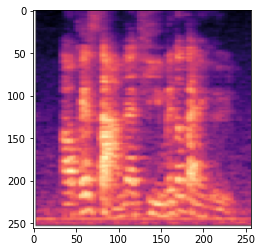

In [ ]:
img_train = (train_dataset * 255).astype('uint8') 
plt.imshow(img_train[1])

In [ ]:
values = train_label
n_values = np.max(values) + 1
train_label = np.eye(n_values)[values]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( train_dataset, train_label, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (256, 256, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True
 
# Create functional model 
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(6)(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])
model.compile(optimizer='adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
 softmax_float32 (Activation  (None, 6)                0         
 )                                                               
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-train

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)


temp  = model.fit(X_train, y_train , epochs = 25 )

Epoch 1/25
84/84 [==============================] - 832s 10s/step - loss: 1.3896 - accuracy: 0.4480
Epoch 2/25
84/84 [==============================] - 806s 10s/step - loss: 1.1909 - accuracy: 0.5393
Epoch 3/25
84/84 [==============================] - 815s 10s/step - loss: 1.0153 - accuracy: 0.6152
Epoch 4/25
84/84 [==============================] - 826s 10s/step - loss: 0.8404 - accuracy: 0.6828
Epoch 5/25
84/84 [==============================] - 838s 10s/step - loss: 0.6702 - accuracy: 0.7508
Epoch 6/25
84/84 [==============================] - 842s 10s/step - loss: 0.4633 - accuracy: 0.8331
Epoch 7/25
84/84 [==============================] - 838s 10s/step - loss: 0.3911 - accuracy: 0.8628
Epoch 8/25
84/84 [==============================] - 850s 10s/step - loss: 0.3422 - accuracy: 0.8858
Epoch 9/25
84/84 [==============================] - 841s 10s/step - loss: 0.2678 - accuracy: 0.9094
Epoch 10/25
84/84 [==============================] - 832s 10s/step - loss: 0.2547 - accuracy: 0.9113

In [ ]:
model.save('/content/drive/MyDrive/SER- Project/EffNetZeroAll_data')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SER- Project/EffNetZeroAll_data/assets


In [ ]:
test_load = tf.keras.models.load_model('/content/drive/MyDrive/SER- Project/EffNetZeroAll_data')

In [ ]:
test_load.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
 softmax_float32 (Activation  (None, 6)                0         
 )                                                               
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-train

In [ ]:
print(5*2)

10


In [ ]:
results = model.evaluate(X_test, y_test)

21/21 [==============================] - 88s 4s/step - loss: 2.4006 - accuracy: 0.5315


In [ ]:
print('loss , Accuracy on test_set : \n ', results)

loss , Accuracy on test_set : 
  [2.400606155395508, 0.5315315127372742]


In [ ]:
train_set_results =  model.evaluate(X_train[0:500], y_train[0:500])

16/16 [==============================] - 72s 5s/step - loss: 0.0250 - accuracy: 0.9880


In [ ]:
print('Loss and Acc in Train set : \n',train_set_results)

Loss and Acc in Train set : 
 [0.024964863434433937, 0.9879999756813049]
